## AIMI High School Internship 2023
### Notebook 2: Training a Vision Model to Predict ET Distances

**The Problem**: Given a chest X-ray, our goal in this project is to predict the distance from an endotracheal tube to the carina. This is an important clinical task - endotracheal tubes that are positioned too far (>5cm) above the carina will not work effectively.

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) annotations indicating the distance of the endotracheal tube from the carina. Now, your goal is to train a computer vision model to predict endotracheal tube distance from the image. You have **two options** for this task, and you may attempt one or both of these:
- *Distance Categorization* : Train a model to determine whether the position of a tube is abnormal (>5.0 cm) or normal (≤ 5.0 cm).
- *Distance Prediction*: Train a model that predicts the distance of the endotracheal tube from the carina in centimeters.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- *Distance Categorization* : We will measure AUROC, which is a metric commonly used in healthcare tasks. See this blog for a good explanation of AUROC: https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- *Distance Prediction*: We will measure the mean average error (also known as L1 distance) between the predicted distances and the true distances.


## Load Data
Before you begin, make sure to go to `Runtime` > `Change Runtime Type` and select a T4 GPU. Then, upload `data.zip`. It should take about 10 minutes for these files to be uploaded. Then, run the following cells to unzip the dataset (which should take < 10 seconds)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/MyDrive/Stanford AIMI Data - ChestGPT/mimic-train.zip" -d "/content"
!unzip "/content/drive/MyDrive/Stanford AIMI Data - ChestGPT/mimic-test.zip" -d "/content"
train_csv = "drive/MyDrive/Stanford AIMI Data - ChestGPT/mapped_data.csv"
test_csv = "drive/MyDrive/Stanford AIMI Data - ChestGPT/mimic_test_student.csv"

Streaming output truncated to the last 5000 lines.
  inflating: /content/mimic-train/15852/52062/84876.jpg  
  inflating: /content/mimic-train/15852/52062/83208.jpg  
   creating: /content/mimic-train/15852/57117/
  inflating: /content/mimic-train/15852/57117/91755.jpg  
   creating: /content/mimic-train/15852/62643/
  inflating: /content/mimic-train/15852/62643/82738.jpg  
  inflating: /content/mimic-train/15852/62643/94153.jpg  
  inflating: /content/mimic-train/15852/57117.txt  
  inflating: /content/mimic-train/15852/62643.txt  
   creating: /content/mimic-train/14415/
   creating: /content/mimic-train/14415/57491/
  inflating: /content/mimic-train/14415/57491/90707.jpg  
  inflating: /content/mimic-train/14415/57491.txt  
   creating: /content/mimic-train/14405/
   creating: /content/mimic-train/14405/53623/
  inflating: /content/mimic-train/14405/53623/91929.jpg  
  inflating: /content/mimic-train/14405/53623.txt  
   creating: /content/mimic-train/16554/
  inflating: /content/mi

In [ ]:
train_csv = "drive/MyDrive/Stanford AIMI Data - ChestGPT/mapped_data.csv"
test_csv = "drive/MyDrive/Stanford AIMI Data - ChestGPT/mimic_test_student.csv"

In [ ]:
!unzip -qq /content/mimic-train.zip

In [ ]:
!unzip -qq /content/mimic-test.zip

## Import Libraries
We are leveraging the PyTorch framework to train our models. For more information and tutorials on PyTorch, see this link: https://pytorch.org/tutorials/beginner/basics/intro.html

In [4]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install torchmetrics
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import os


## Create Dataloaders
We will implement a custom Dataset class to load in data. A custom Dataset class must have three methods: `__init__`, which sets up any class variables, `__len__`, which defines the total number of images, and `__getitem__`, which returns a single image and its paired label.

In [5]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class ChestXRayDataset(Dataset):
    def __init__(self, annotations_file, targ_dir='', transform=None):
        super(ChestXRayDataset, self).__init__()
        self.image_info = pd.read_csv(annotations_file, usecols=[1, 3])
        self.image_paths = self.image_info.iloc[:, 0]
        self.image_labels = self.image_info.iloc[:, 1]
        self.transform = transform

    def load_image(self, index: int) -> Image.Image:
        image_path = self.image_paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.image_info)

    def __getitem__(self, index: int):
      image = Image.open(self.image_paths[index])
      label = self.image_labels[index]

      return self.transform(image), label




In [6]:
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from sklearn.model_selection import train_test_split


simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1))

])

train_labels = "drive/MyDrive/Stanford AIMI Data - ChestGPT/mapped_data.csv"

train_images = "/content/mimic-train"

# Create an object of the ChestXRayDataset class
training_data = ChestXRayDataset(train_labels, targ_dir = train_images, transform = simple_transform)


"""train_indices, val_indices = train_test_split(range(len(training_data)), test_size=0.2, random_state=42)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)"""



'train_indices, val_indices = train_test_split(range(len(training_data)), test_size=0.2, random_state=42)\ntrain_sampler = torch.utils.data.SubsetRandomSampler(train_indices)\nval_sampler = torch.utils.data.SubsetRandomSampler(val_indices)'

## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [13]:
from torchvision.models import resnet101
import torch.nn as nn
import torch
import torch.optim.lr_scheduler as lr_scheduler


loss = nn.SmoothL1Loss()  # Loss Function - look at MSE
model = resnet101(pretrained=True)  # Load pre-trained weights
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout with a dropout rate of 0.5 (adjust as needed)
    nn.Linear(num_features, 1)
)
if torch.cuda.is_available():
    # Move the model to the GPU
    model = model.to("cuda")
for param in model.fc.parameters():
    param.requires_grad = True
model.float()

opt = torch.optim.Adam(model.parameters(), lr=1e-4)  # AdamW optimizer - decrease learning rate
scheduler = lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)

# Split the dataset into train and validation sets
train_size = int(0.75 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])






/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 62.2MB/s]


In [14]:
# Calculate the target values for the training dataset
train_labels = []
train_indices = []
threshold = 20  # Adjust as needed

for index, (images, labels) in enumerate(train_dataset):
    if labels <= threshold:
        train_labels.append(labels.item())
        train_indices.append(index)

# Convert training labels to a NumPy array
train_labels = np.array(train_labels)

# Apply the indices to create a new training dataset without outliers
train_dataset = torch.utils.data.dataset.Subset(train_dataset, train_indices)

# Calculate the target values for the validation dataset
val_labels = []
val_indices = []

for index, (images, labels) in enumerate(val_dataset):
    if labels <= threshold:
        val_labels.append(labels.item())
        val_indices.append(index)

# Convert validation labels to a NumPy array
val_labels = np.array(val_labels)

# Apply the indices to create a new validation dataset without outliers
val_dataset = torch.utils.data.dataset.Subset(val_dataset, val_indices)


In [15]:
# Create data loaders for training and validation
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=32, sampler=train_sampler)
#val_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=32, sampler=val_sampler)

In [16]:
train_labels = []
for images, labels in train_loader:
    train_labels.extend(labels.tolist())

# Convert training labels to a NumPy array
train_labels = np.array(train_labels)

# Calculate the quartiles and interquartile range (IQR) for the training dataset
train_q1 = np.percentile(train_labels, 25)
train_q3 = np.percentile(train_labels, 75)
train_iqr = train_q3 - train_q1

# Define a threshold for outliers in the training dataset
threshold = 1.5  # Adjust as needed
train_lower_bound = train_q1 - threshold * train_iqr
train_upper_bound = train_q3 + threshold * train_iqr

# Identify and print outliers in the training dataset
train_outliers = train_labels[(train_labels < train_lower_bound) | (train_labels > train_upper_bound)]
print("Outliers in the training dataset:")
print(train_outliers)

# Calculate the target values for the validation dataset
validation_labels = []
for images, labels in val_loader:
    validation_labels.extend(labels.tolist())

# Convert validation labels to a NumPy array
validation_labels = np.array(validation_labels)

# Calculate the quartiles and interquartile range (IQR) for the validation dataset
val_q1 = np.percentile(validation_labels, 25)
val_q3 = np.percentile(validation_labels, 75)
val_iqr = val_q3 - val_q1

# Define a threshold for outliers in the validation dataset
val_lower_bound = val_q1 - threshold * val_iqr
val_upper_bound = val_q3 + threshold * val_iqr

# Identify and print outliers in the validation dataset
val_outliers = validation_labels[(validation_labels < val_lower_bound) | (validation_labels > val_upper_bound)]
print("Outliers in the validation dataset:")
print(val_outliers)


Outliers in the training dataset:
[11.  10.  15.  20.   9.5 10.   9.3 12.  10.  12.  15.  10.  12.  10.
 10.  10.  10.  11.  10.  12.  15.  10.   9.5 10.  12.   9.5  9.3  9.1
  9.5 12.  10.  15.  14.   9.5 10.  10.  12.  14.8 10.   9.5  9.2 12.
 12.  10.  15.  13.  12.  10.  10.  15.  12.  10.  12.  10.  10.  12.
 10.   9.5  9.1 15.  10.  10.  12.  10.   9.5 10.  15.  10.  15.  12.
  9.1  9.8 11.  12. ]
Outliers in the validation dataset:
[10.  12.  10.  12.  11.  10.   9.3 10.  12.  15.  12.  15.  10.  20.
  9.9 15.  12.  10.  12.  10.  10.  10.  10.   9.5 11.   9.2 10.  10.
  9.1 10. ]


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, loss_fn, train_loader, val_loader, opt, scheduler, max_epoch):
    best_val_loss = np.inf
    best_val_metrics = []
    train_losses = []
    val_losses = []

    for epoch in range(max_epoch):
        model.train()
        epoch_loss = 0.0

        for step, (inputs, targets) in tqdm(enumerate(train_loader)):

            opt.zero_grad()
            inputs = inputs.to("cuda")
            targets = targets.to("cuda").unsqueeze(1).float()  # Convert to float tensor

            #print(f"Input Size: {inputs.size()}")
            #print(f"Target Size: {targets.size()}")
            # Forward pass
            pred = model(inputs)  # Compute prediction
            #print(f"Output Size: {pred.size()}")
            # Compute loss
            loss = loss_fn(pred, targets)  # Compute loss
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            opt.step()

            # Update progress or perform evaluation, if desired
            #print(f"Loss Size: {loss.item()}")
        # Calculate average training loss for the epoch
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {epoch_loss}")

        # Perform evaluation on the validation set
        val_loss = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss

        scheduler.step(val_loss)


    # Plotting the training and validation losses
    epochs = range(1, max_epoch + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return best_val_loss


def evaluate(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            targets = targets.to("cuda").unsqueeze(1).float()  # Convert to float tensor
            inputs = inputs.to("cuda").float()  # Convert to float tensor


            # Forward pass
            pred = model(inputs)

            # Calculate loss
            loss = loss_fn(pred, targets)
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)

    return average_loss



887it [02:17,  6.45it/s]


Epoch 1 - Training Loss: 0.9336233601024482
Epoch 1 - Validation Loss: 0.808915596354652


887it [02:18,  6.40it/s]


Epoch 2 - Training Loss: 0.7404350762537931
Epoch 2 - Validation Loss: 0.69673137261054


887it [02:17,  6.46it/s]


Epoch 3 - Training Loss: 0.6505623821677323
Epoch 3 - Validation Loss: 0.706172922374429


887it [02:17,  6.45it/s]


Epoch 4 - Training Loss: 0.5666982315001923
Epoch 4 - Validation Loss: 0.711463394373454


887it [02:17,  6.46it/s]


Epoch 5 - Training Loss: 0.46974469211242315
Epoch 5 - Validation Loss: 0.7080123777174063


887it [02:17,  6.45it/s]


Epoch 6 - Training Loss: 0.38195896317306677
Epoch 6 - Validation Loss: 0.7353503754664514


887it [02:17,  6.46it/s]


Epoch 7 - Training Loss: 0.309254161767838
Epoch 7 - Validation Loss: 0.7226536651016087


887it [02:19,  6.37it/s]


Epoch 8 - Training Loss: 0.26046545142066385
Epoch 8 - Validation Loss: 0.6726159704597415


887it [02:17,  6.45it/s]


Epoch 9 - Training Loss: 0.22256719118578458
Epoch 9 - Validation Loss: 0.7100056126411702


887it [02:17,  6.45it/s]


Epoch 10 - Training Loss: 0.19871646332267878
Epoch 10 - Validation Loss: 0.7528282834367978


887it [02:17,  6.47it/s]


Epoch 11 - Training Loss: 0.17565488338306665
Epoch 11 - Validation Loss: 0.6848698644521268


887it [02:17,  6.47it/s]


Epoch 12 - Training Loss: 0.16296736723633132
Epoch 12 - Validation Loss: 0.6716875049562471


887it [02:17,  6.46it/s]


Epoch 13 - Training Loss: 0.14164392656847213
Epoch 13 - Validation Loss: 0.6851924034087239


887it [02:17,  6.47it/s]


Epoch 14 - Training Loss: 0.12848473835070834
Epoch 14 - Validation Loss: 0.6506343970603838


887it [02:17,  6.47it/s]


Epoch 15 - Training Loss: 0.12466739976028948
Epoch 15 - Validation Loss: 0.7083524681527067


887it [02:17,  6.47it/s]


Epoch 16 - Training Loss: 0.12300291069360132
Epoch 16 - Validation Loss: 0.6848434736650135


887it [02:17,  6.47it/s]


Epoch 17 - Training Loss: 0.11806127791982796
Epoch 17 - Validation Loss: 0.6821610730242085


887it [02:16,  6.48it/s]


Epoch 18 - Training Loss: 0.09466790409470996
Epoch 18 - Validation Loss: 0.6757695206717865


887it [02:17,  6.47it/s]


Epoch 19 - Training Loss: 0.08558434371446945
Epoch 19 - Validation Loss: 0.659984614272174


887it [02:17,  6.46it/s]


Epoch 20 - Training Loss: 0.08855439457420801
Epoch 20 - Validation Loss: 0.6568258190527558
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.


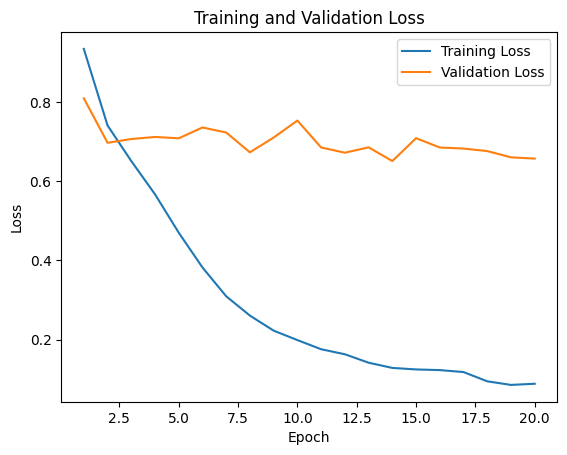

0.6506343970603838

In [18]:
train(model, loss, train_loader, val_loader, opt, scheduler, max_epoch=20)
#add regularization/dropout to prevent overfitting

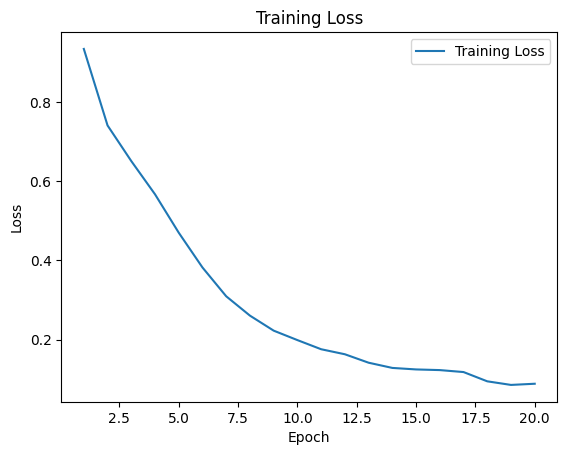

In [28]:
training_losses = [
    0.9336233601024482,
    0.7404350762537931,
    0.6505623821677323,
    0.5666982315001923,
    0.46974469211242315,
    0.38195896317306677,
    0.309254161767838,
    0.26046545142066385,
    0.22256719118578458,
    0.19871646332267878,
    0.17565488338306665,
    0.16296736723633132,
    0.14164392656847213,
    0.12848473835070834,
    0.12466739976028948,
    0.12300291069360132,
    0.11806127791982796,
    0.09466790409470996,
    0.08558434371446945,
    0.08855439457420801
]

validation_losses = [
    0.808915596354652,
    0.69673137261054,
    0.706172922374429,
    0.711463394373454,
    0.7080123777174063,
    0.7353503754664514,
    0.7226536651016087,
    0.6726159704597415,
    0.7100056126411702,
    0.7528282834367978,
    0.6848698644521268,
    0.6716875049562471,
    0.6851924034087239,
    0.6506343970603838,
    0.7083524681527067,
    0.6848434736650135,
    0.6821610730242085,
    0.6757695206717865,
    0.659984614272174,
    0.6568258190527558
]

plt.plot(range(1, 20+1), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [19]:
from google.colab import files
save_path = '/content/resnet101_20epoch_regression_model.pth'
torch.save(model.state_dict(), save_path)
files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import pandas as pd

# Specify the path to the CSV file
csv_file = test_csv

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)
df.drop(df.columns.difference(['image_path']), axis=1, inplace=True)


In [21]:
output_file = '/content/test_image_paths.csv'

# Save the DataFrame as a CSV file
df.to_csv(output_file, index=False)
files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard.

Your final `.csv` file **must** have the following format:
- There must be a column titled `image_path` with the paths to the test set images. This column should be identical to the one provided in `mimic_test_student.csv`.
- There must be a column titled `pred` with your model outputs.
  - If you are running the `distance categorization` task, this column must have floating point numbers ranging between 0 and 1. Higher numbers should indicate a greater likelihood that the tube distance is abnormal. Hint: You can convert model outputs to the 0 to 1 range by applying the sigmoid activation function (torch.nn.sigmoid())
  - If you are running the `distance prediction` task, this column must have numbers representing the tube distance in centimeters.
- Double check that there are 500 rows in your output file

In [22]:
ckpt = torch.load("/content/resnet101_20epoch_regression_model.pth")
model.load_state_dict(ckpt)

from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class TestChestXRayDataset(Dataset):
    def __init__(self, annotations_file, targ_dir='', transform=None):
        super(TestChestXRayDataset, self).__init__()
        self.image_info = pd.read_csv(annotations_file)
        self.image_paths = self.image_info.iloc[:, 0]
        self.transform = transform

    def load_image(self, index: int) -> Image.Image:
        image_path = self.image_paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.image_info)

    def __getitem__(self, index: int):
      image = Image.open(self.image_paths[index])

      return self.transform(image)

test_dataset = TestChestXRayDataset(output_file, targ_dir="/content/mimic-test", transform=simple_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

test_results = {"image_path": [], "pred": []}






In [23]:
def compute_predictions(model, data_loader, dataset):
    model.eval()
    predictions = []
    total_loss = 0

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs.to("cuda").float()  # Convert to float tensor


            # Forward pass
            pred = model(inputs)
            pred = pred.squeeze().tolist()
            image_paths = [dataset.image_paths[i] for i in range(len(inputs))]

            # Append image paths and predictions to the results list
            predictions.extend(list(zip(image_paths, pred)))

    return predictions


test_predictions = compute_predictions(model, test_loader, test_dataset)



In [24]:
import csv
import pandas as pd

# Save test results to a CSV file
csv_path = "/content/test_results.csv"
with open(csv_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_path", "tube_distance"])  # Write header

    for image_path, pred in test_predictions:
        writer.writerow([image_path, pred])

# Download the CSV file
def download_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.to_csv("/content/test_results.csv", index=False)

download_csv(csv_path)
